<a href="https://colab.research.google.com/github/ajuni-sohota/salarypredictionportfolio/blob/main/Salary_Predictions_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

#### ---- 1 Define the problem ----

For the following datasets containing information on job descriptions, I will build a model that uses predictive analytics techniques to predict the salary for different occupations. One such implementation of this are found in job search engines where the estimated salary is provided for those that are on the hunt for a new job. This is useful because job seekers can then focus on applying for jobs that are within their goal salary range.

In [13]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")


__author__ = "Ajuni Sohota"
__email__ = "ajunisohota@gmail.com"

In [14]:
#pip install geopandas


In [15]:
#pip install dataframe_image

In [16]:
#pip install ast

In [17]:
import geopandas as gpd
import dataframe_image as dfi
from ast import literal_eval

In [18]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import xgboost as xgb
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import learning_curve, ShuffleSplit, RepeatedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

## Part 2 - DISCOVER

#### ---- 2 Load the data ----

In [19]:
#load the data into a Pandas dataframe
train_features = pd.read_csv("train_features.csv")
train_salary = pd.read_csv("train_salaries.csv")
test_features = pd.read_csv("test_features.csv")


In [20]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [21]:
train_salary.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [22]:
# merge both train datasets on jobId
train_data = pd.merge(train_features, train_salary, on="jobId")
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [23]:
# check to make sure test_features has same format
test_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [25]:
train_data.shape

(1000000, 9)

#### ---- 3 Clean the data ----

Looking for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and removing it.

In [26]:
# search for duplicate data
train_data.duplicated().sum()

0

There is no duplicated data in this dataset.

In [27]:
# search for null data
train_data.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [28]:
# search for salaries <= 0 to remove
train_data[train_data['salary']<=0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


There are 5 datapoints where the salary is listed as 0, I will drop these data points because these won't help us to predict salaries.

In [29]:
# update train_data to drop the above datapoints
train_data = train_data[train_data['salary']>0]
train_data.info

<bound method DataFrame.info of                    jobId companyId  ... milesFromMetropolis salary
0       JOB1362684407687    COMP37  ...                  83    130
1       JOB1362684407688    COMP19  ...                  73    101
2       JOB1362684407689    COMP52  ...                  38    137
3       JOB1362684407690    COMP38  ...                  17    142
4       JOB1362684407691     COMP7  ...                  16    163
...                  ...       ...  ...                 ...    ...
999995  JOB1362685407682    COMP56  ...                  94     88
999996  JOB1362685407683    COMP24  ...                  35    160
999997  JOB1362685407684    COMP23  ...                  81     64
999998  JOB1362685407685     COMP3  ...                   5    149
999999  JOB1362685407686    COMP59  ...                  11     88

[999995 rows x 9 columns]>

#### ---- 4 Explore the data (EDA) ----

In [30]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

##### Feature Variables Summaries: (Continuous Variables)
Shows summary of all continuous variables. The target variable is included: salary.

In [31]:
train_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


##### Feature Variables Summaries: (Categorical Variables)

In [32]:
train_data.describe(include=['O'])

,jobId,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995,999995
unique,999995,63,8,5,9,7
top,JOB1362684472157,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236975,532353,143205


<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Salary')

Text(0.5, 1.0, 'Distribution of Salary')

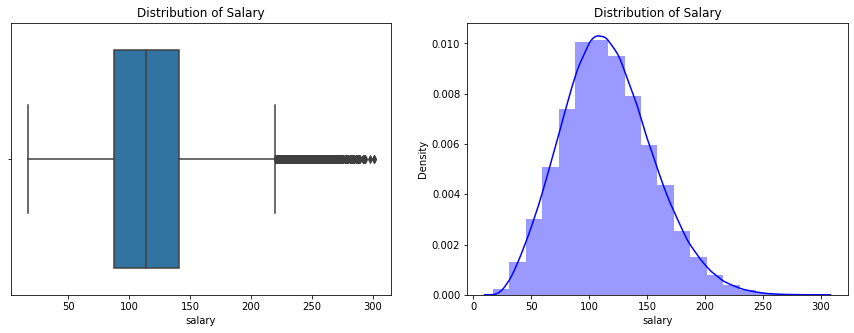

In [33]:
# looking for outliers
# distribution visualizations for salary (boxplox and displot)
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
sns.boxplot(x = train_data['salary']) #boxplot
plt.title("Distribution of Salary")
plt.subplot(1,2,2)
sns.distplot(train_data['salary'], bins =20, color= "blue") #distplot
plt.title("Distribution of Salary")
# plt.savefig("Salary_Outliers.png")
plt.show()

From observing the distributions of the boxplot and displot, we can see that there is a normal distribution with some outliers. I will further explore the outliers and see what categories they fall under so that I can decide if it will be appropriate to drop them or keep them.

In [34]:
def cal_quartiles(col):
    sorted(col)
    q1,q3 = col.quantile([0.25, 0.75])
    IQR = q3-q1
    upper = q3 + (1.5 * IQR)
    lower = q1 - (1.5 * IQR)
    return upper, lower

uppersal, lowersal = cal_quartiles(train_data['salary'])
print("The upper salary is {} and the lower salary is {}.".format(uppersal, lowersal))

The upper salary is 220.5 and the lower salary is 8.5.


In [35]:
# show the salaries higher than the "upper salaries"
train_data[train_data['salary'] > uppersal]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
...,...,...,...,...,...,...,...,...,...
998516,JOB1362685406203,COMP29,CFO,MASTERS,ENGINEERING,WEB,14,46,227
999249,JOB1362685406936,COMP30,CEO,NONE,NONE,OIL,17,10,223
999280,JOB1362685406967,COMP2,CFO,BACHELORS,BUSINESS,SERVICE,21,0,228
999670,JOB1362685407357,COMP20,CEO,DOCTORAL,LITERATURE,SERVICE,24,14,233


Because this includes so much of the data, it seems like we are probably going to have to keep the data in our analysis. But I'm going to look at value counts for things like jobtype to see if these salaries make sense for what category they fall under. 

In [36]:
train_data.loc[train_data['salary']> uppersal, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Most of these salaries that are in the upper salary quartile are CEOs, CFOs, or CTOs. This makes sense because these are top earners.

In [37]:
# visualizations between feature variables and target variable (salary)
def plot_variables(data, col):
    "Plotting all feature variables in data against target variable col (salary)"
    plt.figure(figsize = (15, 5))
    if data[col].dtype != 'int64':
        plt.subplot(1,2,1)
        # encode categorical values by salary mean
        mean = data.groupby(col)['salary'].mean()
        data[col] = data[col].astype('category')
        levels = mean.sort_values().index.tolist()
        data[col].cat.reorder_categories(levels, inplace = True)
        mean.sort_values().plot(kind = 'bar')
        
    if col not in ['companyId', 'yearsExperience', 'milesFromMetropolis']:
        plt.xticks(rotation = 45)
        plt.xlabel(col)
        plt.ylabel('Salary (Mean) by' + '' + col.capitalize())
        plt.subplot(1,2,2)
        
    if data[col].dtype == 'int64':
        # mean salary of each category
        mean = data.groupby(col)['salary'].mean()
        std = data.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), 
                         mean.values - std.values, 
                         mean.values + std.values,
                        alpha = 0.1)
        #plt.savefig("images/salary_each_category_" + col +".png")
    
    else: 
        sns.boxplot(x = col, y = 'salary', data=data)
        plt.xticks(rotation = 45)
        plt.ylabel('Salaries')
        #plt.savefig("images/salary_each_category" + col + ".png")
        plt.show()

In [38]:
cat_variables = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'] 
num_variables = ['yearsExperience', 'milesFromMetropolis', 'salary']
feat_variables = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis'] 

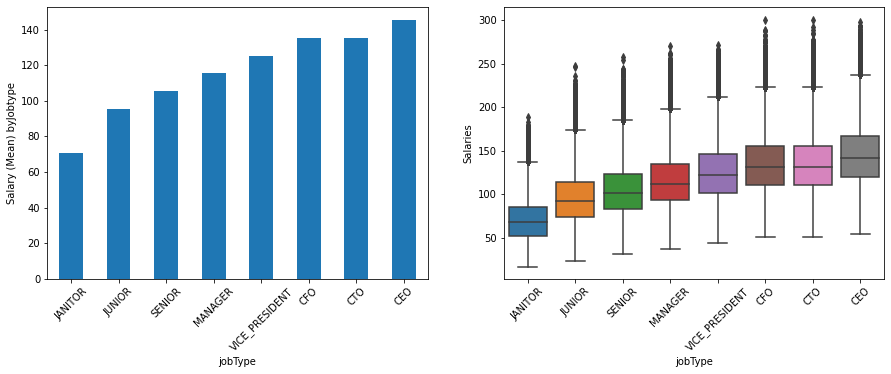

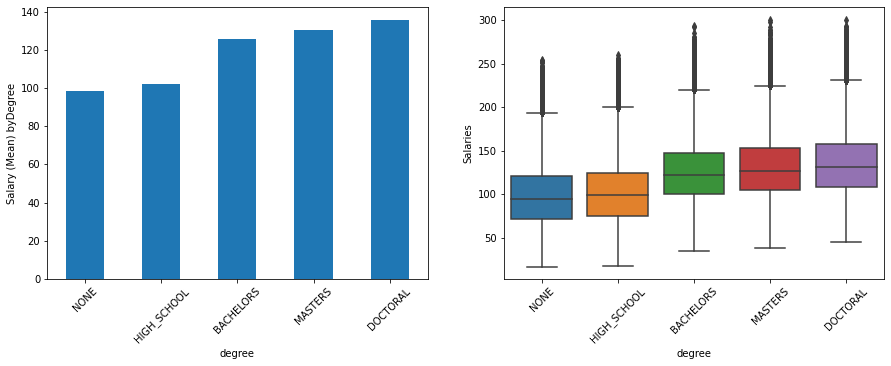

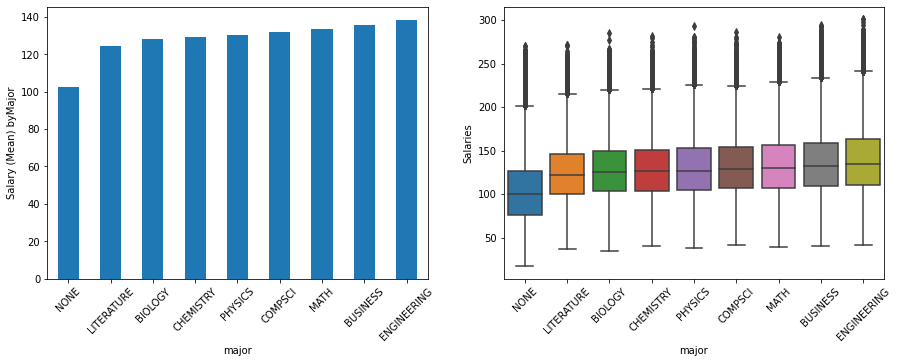

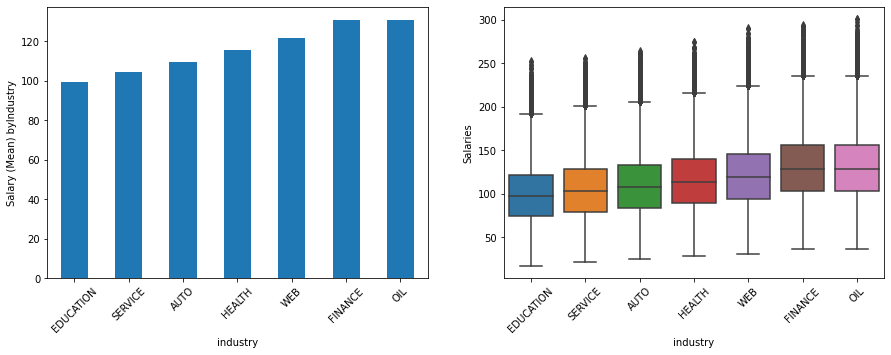

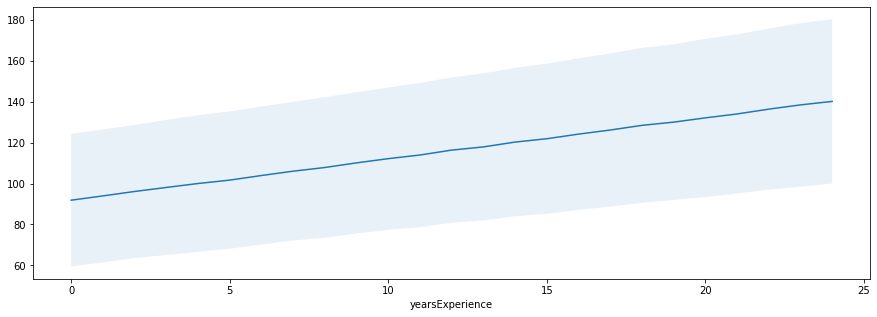

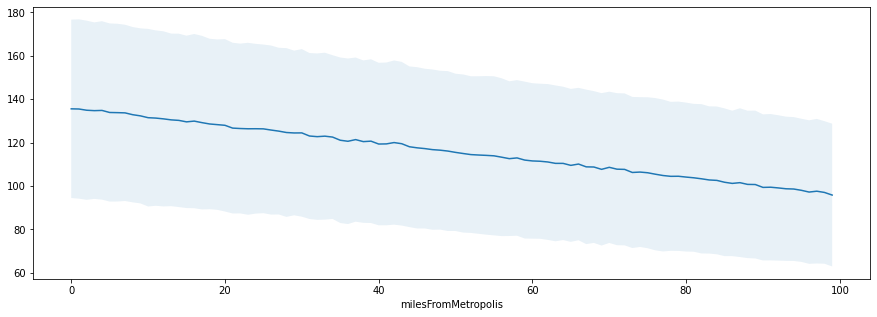

In [39]:
for feature in feat_variables:
    plot_variables(train_data, feature)

In [40]:
# correlations, do not include jobId. create heatmap

In [41]:
# (encode by salary) encoding for categorical variables
def encode_label(data, col):
    """ Encode the categories using average salary for each category to replace label.
    """
    cat_dict = {}
    cats = data[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_data[train_data[col] == cat]['salary'].mean()
    data[col] = data[col].map(cat_dict)

In [42]:
train_data_copy = train_data.copy()
for col in train_data_copy.columns:
    if train_data_copy[col].dtype.name == 'category':
        encode_label(train_data_copy, col)
        train_data_copy[col] = train_data_copy[col].astype('float')

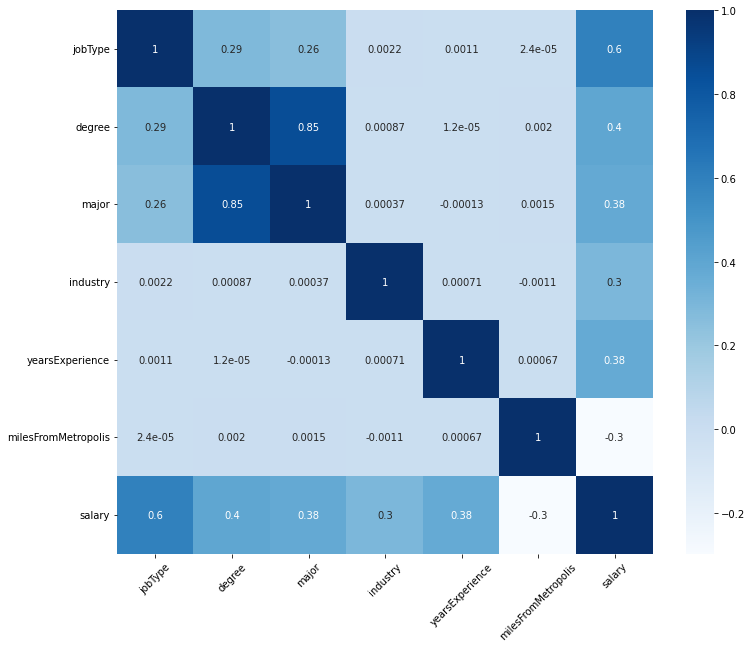

In [43]:
fig = plt.figure(figsize=(12, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(train_data_copy[features + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
#plt.savefig("images/correlation_matrix_heatmap.png")
plt.show();


#### Summary of EDA/Data Cleaning:



#### ---- 5 Establish a baseline ----

In [44]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

# using average salary as a baselline

mse_base = mean_squared_error(train_data_copy['industry'], train_data_copy['salary'])
mse_base

1367.122950785255

In [45]:
# try again with jobType because that has the highest correlation to salary
mse_base2 = mean_squared_error(train_data_copy['jobType'], train_data_copy['salary'])
mse_base2

963.9252996562975

#### ---- 6 Hypothesize solution ----

In [46]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

### Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

#### ---- 7 Engineer features  ----


In [47]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   jobId                999995 non-null  object  
 1   companyId            999995 non-null  object  
 2   jobType              999995 non-null  category
 3   degree               999995 non-null  category
 4   major                999995 non-null  category
 5   industry             999995 non-null  category
 6   yearsExperience      999995 non-null  int64   
 7   milesFromMetropolis  999995 non-null  int64   
 8   salary               999995 non-null  int64   
dtypes: category(4), int64(3), object(2)
memory usage: 89.6+ MB


In [48]:
#feature engineering
cat_variables = ['jobType', 'degree', 'major', 'industry'] 
num_variables = ['yearsExperience', 'milesFromMetropolis', 'salary']
feat_variables = ['jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis'] 

In [49]:
# dummy vars for cat vars
dummy_features_train = pd.get_dummies(train_data[cat_variables], drop_first=True)
train_df = pd.concat([dummy_features_train, train_data[num_variables]], axis=1)
train_df.head(5)

,jobType_JUNIOR,jobType_SENIOR,jobType_MANAGER,jobType_VICE_PRESIDENT,jobType_CFO,jobType_CTO,jobType_CEO,degree_HIGH_SCHOOL,degree_BACHELORS,degree_MASTERS,degree_DOCTORAL,major_LITERATURE,major_BIOLOGY,major_CHEMISTRY,major_PHYSICS,major_COMPSCI,major_MATH,major_BUSINESS,major_ENGINEERING,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL,yearsExperience,milesFromMetropolis,salary
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,10,83,130
1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,73,101
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,10,38,137
3,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,8,17,142
4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,8,16,163


In [50]:

# split the data into train and test sets with test size at 30%
X_train, X_test, Y_train, Y_test = train_test_split(train_df.iloc[:,:-1], train_df.salary, test_size=0.3)

In [51]:
# Confirming the rows and columns are the 
# same for train and test data
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(699996, 27)
(299999, 27)
(699996,)
(299999,)


#### ---- 8 Create models ----


In [52]:
def base_models (model, X_train, X_test, y_train, y_test):
    """
    Function to fit and predict for each model
    
    Parameters:
    
    model, X_train, X_test, y_train, y_test
    
    Returns:
    
    MSE
    
    """
    start_time = time.time()
    
    model.fit(X_train, y_train)
    
    predict_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, predict_train)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("---" + str(time_taken) + " minutes ---")
    
    print("MSE: Train Data " + str(round(mse_train,2)))

In [53]:
def display_scores(model, X_train, y_train):
    """
    Function for cross validation scores
    
    Parameters:
    
    model, X_train, y_train
    
    Returns:
    
    MSE -- Scores, Avg, and Standard Dev
    
    """
    
    cv = 5
    
    start_time = time.time()
    
    scores = cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv=cv)
    mse_scores = -1.0 * (scores)
    
    time_taken = round(((time.time() - start_time) / 60),3)
    
    print("--- " + str(time_taken) + " minutes ---")
    print("MSE Scores:", mse_scores)
    print("MSE Mean:", mse_scores.mean())
    print("Standard deviation of MSE scores:", mse_scores.std())
    

In [55]:
import sklearn

<b>Base Evaluation: Fitting the training data with hypothesized models</b>

In [56]:
# Fit X_train

In [57]:
# Linear Regression - Base Model
lm = LinearRegression()
base_models(lm, X_train, X_test, Y_train, Y_test)

---0.015 minutes ---
MSE: Train Data 384.95


In [58]:
# Random Forest Regression - Base Model
forest_reg = RandomForestRegressor(n_estimators=150, max_depth=25, max_features=25, random_state=0, min_samples_split=60)
base_models(forest_reg, X_train, X_test, Y_train, Y_test)

---5.48 minutes ---
MSE: Train Data 326.07


In [59]:
# Gradient Boosting Regressor - Base Model
grad_booreg = GradientBoostingRegressor(n_estimators=150, max_depth=7, loss='ls', verbose=0)
base_models(grad_booreg, X_train, X_test, Y_train, Y_test)

---4.54 minutes ---
MSE: Train Data 350.53


In [60]:
# XGBRegressor - Base Model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
base_models(xg_reg, X_train, X_test, Y_train, Y_test)

---0.977 minutes ---
MSE: Train Data 427.93


In [61]:
#create and tune the models that you brainstormed during part 2

#### ---- 9 Test models ----

In [62]:
#do 5-fold cross validation on models and measure MSE

In [63]:
# Linear Regression - CV Model
display_scores(lm, X_train, Y_train)


--- 0.064 minutes ---
MSE Scores: [386.99577831 384.83766336 385.8495297  382.23407262 385.03351765]
MSE Mean: 384.99011232713724
Standard deviation of MSE scores: 1.5736692042075284


In [64]:
# Random Forest Regression - CV Model
display_scores(forest_reg, X_train, Y_train)

--- 21.28 minutes ---
MSE Scores: [375.03808115 373.40736226 373.47326399 370.57008965 372.84379185]
MSE Mean: 373.0665177803054
Standard deviation of MSE scores: 1.4457136507098303


In [65]:
# Gradient Boosting Regressor - CV Model
display_scores(grad_booreg, X_train, Y_train)

--- 17.634 minutes ---
MSE Scores: [360.49700749 359.24059982 359.19631621 357.37905995 359.57520186]
MSE Mean: 359.1776370647418
Standard deviation of MSE scores: 1.0137049811888734


In [66]:
# XGBRegressor - CV Model
display_scores(xg_reg, X_train, Y_train)

--- 3.802 minutes ---
MSE Scores: [431.08993996 429.1353443  428.60360646 425.11371423 429.45891704]
MSE Mean: 428.6803043983954
Standard deviation of MSE scores: 1.9670328176607808


#### ---- 10 Select best model  ----

In [69]:
#select the model with the lowest error as your "production" model

models_MSE =pd.DataFrame(({'Models':['Linear regression','Random Forest','Gradient Boosting Regressor', 'XGBRegressor'],
               'Mean Squared Error':[384.38, 372.98, 358.89, 428.17]}))
models_MSE

,Models,Mean Squared Error
0,Linear regression,384.38
1,Random Forest,372.98
2,Gradient Boosting Regressor,358.89
3,XGBRegressor,428.17


### Part 4 - DEPLOY

#### ---- 11 Automate pipeline ----

In [70]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

In [71]:
# Train model on trianing set and save to csv
num_variables.remove('salary')

In [72]:
dummy_features_test = pd.get_dummies(test_features[cat_variables], drop_first=True)
test_df = pd.concat([dummy_features_test, test_features[num_variables]], axis=1)

In [73]:
test_df.head()


,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,degree_DOCTORAL,degree_HIGH_SCHOOL,degree_MASTERS,degree_NONE,major_BUSINESS,major_CHEMISTRY,major_COMPSCI,major_ENGINEERING,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,22,73
1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,20,47
2,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,14,96
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,10,44


In [74]:
# Use best model ()
grad_booreg.fit(train_df.iloc[:,:-1], train_df.salary)


GradientBoostingRegressor(loss='ls', max_depth=7, n_estimators=150)

In [75]:
test_prediction = grad_booreg.predict(test_df) 
prediction = pd.DataFrame(test_prediction).rename(columns={0:'predicted_salary'})

In [76]:
# score the "test" dataset
final_prediction = pd.concat([test_features['jobId'], prediction], axis=1)
final_prediction.head(10)

,jobId,predicted_salary
0,JOB1362685407687,141.906754
1,JOB1362685407688,141.441924
2,JOB1362685407689,136.424769
3,JOB1362685407690,127.004795
4,JOB1362685407691,116.857761
5,JOB1362685407692,97.367184
6,JOB1362685407693,146.130450
7,JOB1362685407694,68.517154
8,JOB1362685407695,110.941977
9,JOB1362685407696,133.159301


#### ---- 12 Deploy solution ----

In [77]:
# save your prediction to a csv file
final_prediction.to_csv("Salary_Predictions.csv", index=False)

#### ---- 13 Feature Importance ----

In [80]:
feature_importance = pd.DataFrame({'features': test_df.columns, 'importance': grad_booreg.feature_importances_})


In [81]:
feature_importance.sort_values(by='importance', ascending=False, inplace=True)


In [85]:
feature_importance.head(10)

,features,importance
25,yearsExperience,0.187274
26,milesFromMetropolis,0.129014
6,jobType_VICE_PRESIDENT,0.107324
5,jobType_SENIOR,0.073871
4,jobType_MANAGER,0.071621
10,degree_NONE,0.055020
3,jobType_JUNIOR,0.054582
8,degree_HIGH_SCHOOL,0.049270
9,degree_MASTERS,0.049247
23,industry_SERVICE,0.037705


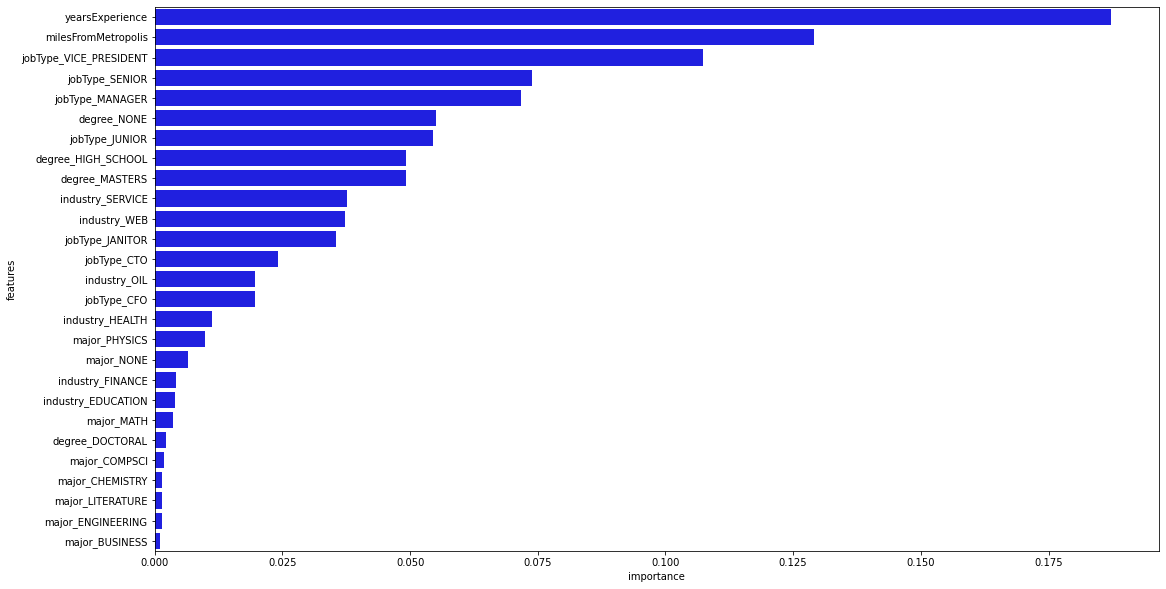

In [82]:
plt.figure(figsize=(18,10))
sns.barplot(x='importance', y='features',color='blue', data=feature_importance)
plt.show();